In [95]:
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
import cv2 
import os

## Bulding PCA model

In [96]:
class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def normalization(self,image):
        temp = deepcopy(image)
        mean = temp.mean(axis=0)
        temp = temp - mean
        self.mean= mean
        return temp
    
    def calc_covariance(self,vector1,vector2) :
        vec1 = deepcopy(vector1)
        vec2 = deepcopy(vector2)
        vec1_mean = vec1.mean()
        vec2_mean = vec2.mean()
        vec1 = vec1-vec1_mean
        vec2 = vec2-vec2_mean
        vec2 = vec2.T
        return (np.dot(vec1,vec2)/(len(vec1)-1))

    def covariance(self,image):
        temp = deepcopy(image)
        temp = temp.T
        covariance_matrix= np.zeros((len(image[0]),len(image[0])))
        for component1 in range(len(temp)):
            for component2 in range(len(temp)):
                variance =self.calc_covariance(temp[component1],temp[component2])
                covariance_matrix[component1][component2]= variance
        return covariance_matrix

    def calc_eign(self,matrix):
        eigen_values,eigen_vectors = np.linalg.eig(matrix)
        return eigen_values,eigen_vectors


    def fit(self,image):
        normalized_img = self.normalization(image)

        covariance_matrix = self.covariance(normalized_img)

        eigen_values,eigen_vectors = self.calc_eign(covariance_matrix) 
        eigen_vectors = eigen_vectors.T   
        indecis = np.argsort(eigen_values)[::-1]
        eigen_values =eigen_values[indecis]
        eigen_vectors = eigen_vectors[indecis]

        self.components= eigen_vectors[:self.n_components]
    def transform(self,image):
        temp = deepcopy(image)
        temp = temp - self.mean
        new_image = np.dot(temp,self.components.T)
        return np.array(new_image)

    def reverse(self,image):
        result =np.dot(image,self.components)

        return result+self.mean

## PCA on one gray image

### Helper Functions

In [97]:
def readimage(path):
        img =cv2.imread(path)
        img = cv2.resize(img,(500,500))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        return img

### Code

In [98]:
image = readimage('data/test.jpg')
image.shape

(500, 500)

2000000
80000
pca image shape:  (500, 20)


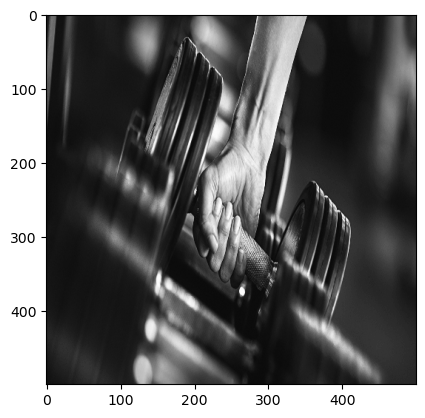

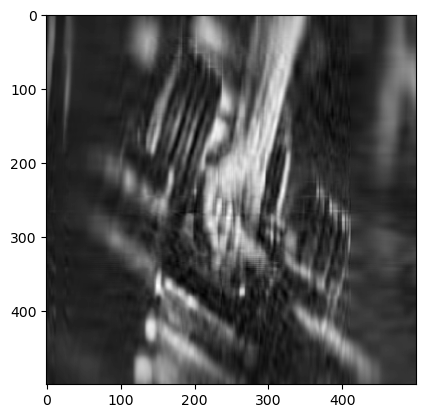

image size: 2000000, 
PCA's image size: 80000, 
reverrsed image size: 2000000


In [107]:
pca = PCA(n_components=20)
pca.fit(image)
image = np.array(image, dtype=np.float64)
pca_image= pca.transform(image)
print(image.nbytes)
print(pca_image.nbytes)
pca_reverse = pca.reverse(pca_image) 
pca_reverse = np.real(pca_reverse)
print("pca image shape: ",pca_image.shape)
plt.imshow(image,cmap="gray")
plt.show()
plt.imshow(pca_reverse,cmap="gray")
plt.show()

print("image size: {}, \nPCA's image size: {}, \nreverrsed image size: {}".format(image.nbytes, pca_image.nbytes, pca_reverse.nbytes))

## PCA on Multi-Images

### Helper Functions

In [84]:
class Flatten():
    def __init__(self):
        pass
    def flatten(self,images):
        flattened_images = [image.reshape(-1) for image in images]
        self.original_shape = images[0].shape  
        return np.array(flattened_images)

    
    def deflatten(self, images):
      
        return [image.reshape(self.original_shape) for image in images]


In [85]:
def readimage(path):
        img =cv2.imread(path)
        img = cv2.resize(img,(15,15))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        return img

In [86]:
def plot_images(images,type= " "):

    num_images = len(images)
    grid_size = int(num_images ** 0.5) + 1 

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    axes = axes.flatten()

    for i, image in enumerate(images):
        if type != "gray":
            axes[i].imshow(image)
        else:
            temp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            axes[i].imshow(temp, cmap='gray')
        axes[i].axis('off')
        

    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()  
    plt.show()



### Code

In [87]:
pathes =os.listdir('data')[1:]

images = np.array([readimage(os.path.join("data",img)) for img in pathes])

flatten = Flatten()
flat_imgs = flatten.flatten(images)
flat_imgs.shape


(6, 675)

In [88]:
pca = PCA(n_components=500)
pca.fit(flat_imgs)

In [89]:

pca_imgs=pca.transform(flat_imgs)
reversed_imgs = pca.reverse(pca_imgs)
new_imgs =flatten.deflatten(reversed_imgs)
new_imgs = np.real(new_imgs)


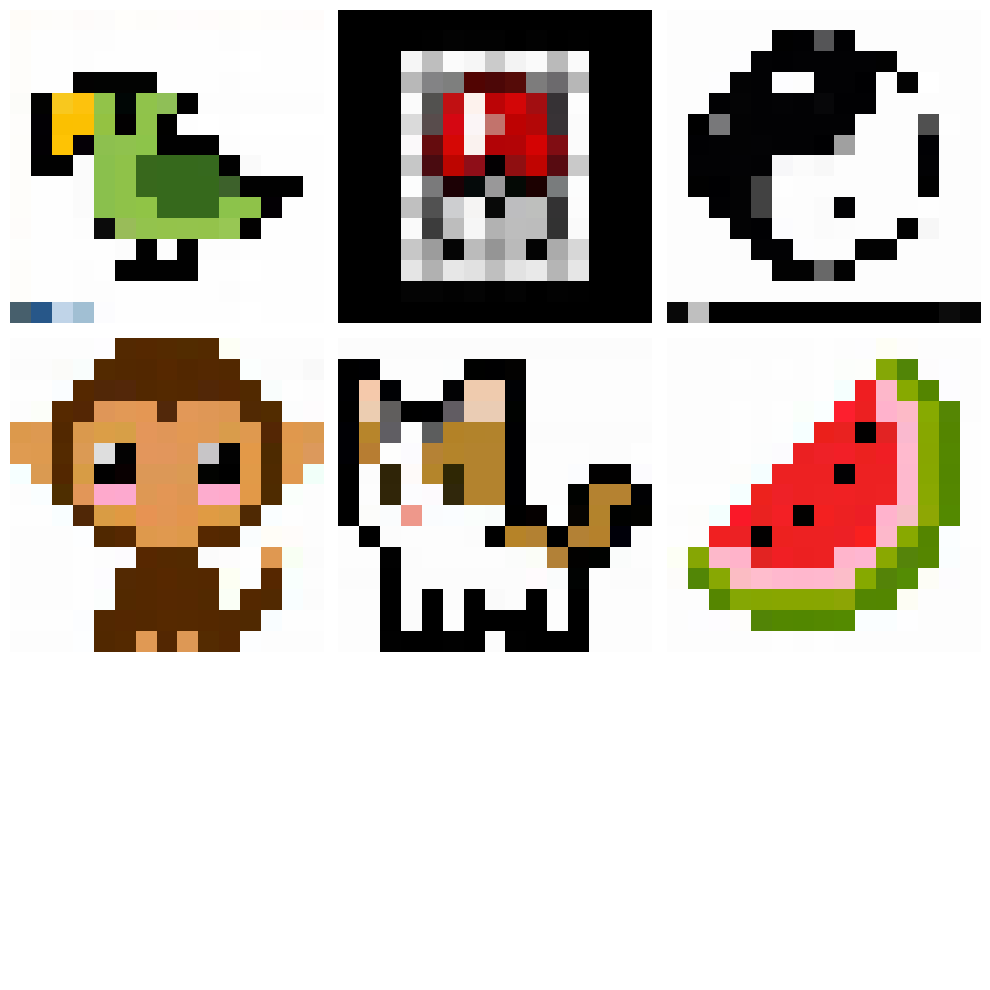

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


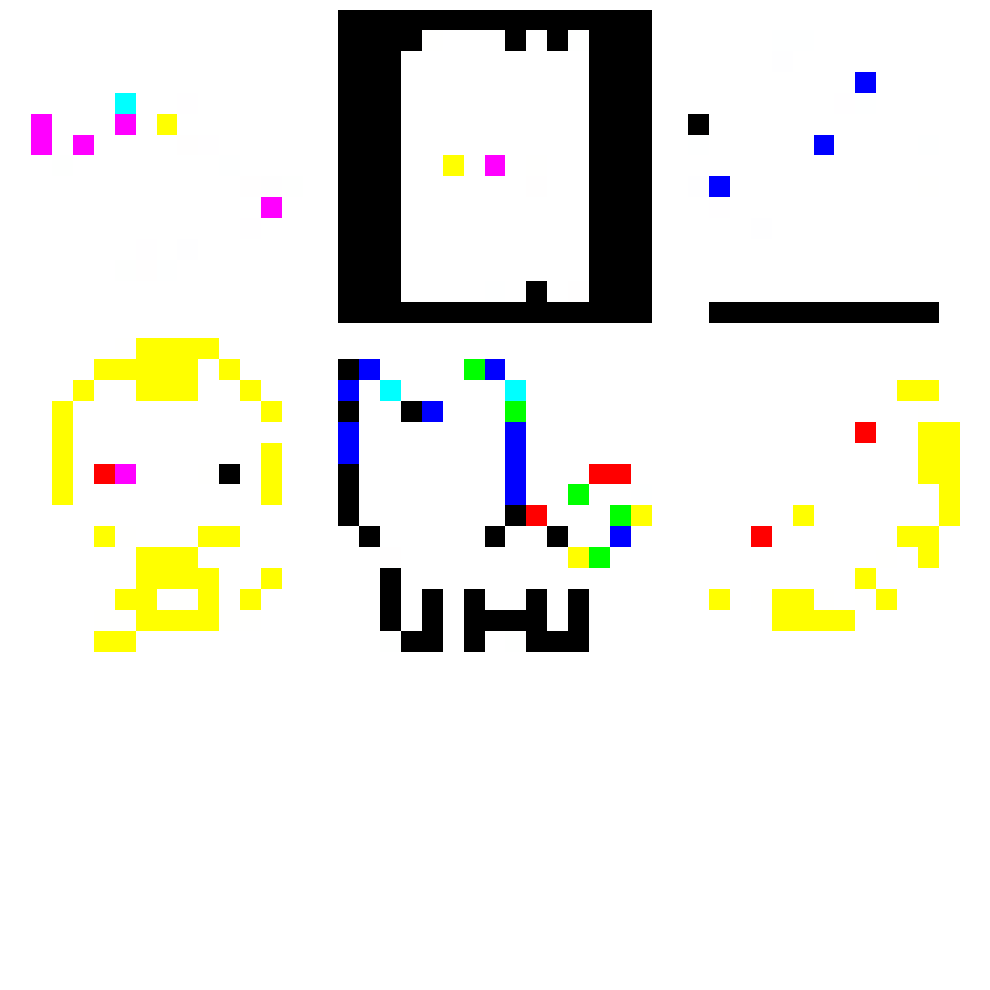

image size: 4050, 
PCA's image size: 48000, 
reverrsed image size: 32400
the above images in different data types this is why its not has resonable sizes
image size: 32400, 
PCA's image size: 24000, 
reverrsed image size: 32400


In [106]:
plot_images(images)
plot_images(new_imgs)
print("image size: {}, \nPCA's image size: {}, \nreverrsed image size: {}".format(images.nbytes, pca_imgs.nbytes, new_imgs.nbytes))
print("============================\nthe above images in different data types this is why its not has resonable sizes\n=========================")
print("image size: {}, \nPCA's image size: {}, \nreverrsed image size: {}".format(np.array(images,dtype=np.float64).nbytes, np.array(np.real(pca_imgs),dtype=np.float64).nbytes, np.array(new_imgs,dtype=np.float64).nbytes))

image size: <class 'numpy.ndarray'>, 4050 <br>
PCA's image size: <class 'numpy.complex128'>, 48000 <br>
reverrsed image size: <class 'numpy.ndarray'> 32400 <br>